In [1]:
import sys, pickle
print(sys.executable)
import sklearn.preprocessing as pre, scipy, numpy as np, matplotlib.pyplot as plt, glob, os, pyemma
import pandas as pd, seaborn as sns, argparse

#from temp_tf_load import *
sys.path.append('../../hde')
print(sys.path)
import warnings
warnings.filterwarnings('ignore')
from hde import HDE, analysis

/home/mikejones/scratch-midway2/conda_envs/srv_env/bin/python
['/scratch/midway2/mikejones/srv/implicit/Analysis', '/home/mikejones/scratch-midway2/conda_envs/srv_env/lib/python37.zip', '/home/mikejones/scratch-midway2/conda_envs/srv_env/lib/python3.7', '/home/mikejones/scratch-midway2/conda_envs/srv_env/lib/python3.7/lib-dynload', '', '/home/mikejones/.local/lib/python3.7/site-packages', '/home/mikejones/scratch-midway2/conda_envs/srv_env/lib/python3.7/site-packages', '/home/mikejones/scratch-midway2/conda_envs/srv_env/lib/python3.7/site-packages/IPython/extensions', '/home/mikejones/.ipython', '../../hde']


Using TensorFlow backend.


In [2]:
class seqObj:
    
    def __init__(self, meta_dir, state_list, nstates, nmodes, diag_path, minflux=5e-6):
        
        self.meta_dir = meta_dir
        self.state_list = state_list
        self.nstates = nstates
        self.nmodes = nmodes
        self.minflux = minflux
        self.diag_path = diag_path
        
seq_dict = {}
seq_dict['AT-all'] =  seqObj(meta_dir='../../paper_notebooks/hde_outputs/save_metatrajs/AT-all_306K_112-165001-190_200micro_6macro/',
                      state_list=['3p-shift4', '3p-shift2', '5p-shift4', '5p-shift2', 'Hybridized', 'Dissociated'],
                      diag_path = '../../paper_notebooks/hde_outputs/Analysis/AT-all_data_diag.npy',
                      nstates= 6, nmodes = 5, minflux=5e-6)

seq_dict['GC-end'] =  seqObj(meta_dir='../../paper_notebooks/hde_outputs/save_metatrajs/save_metatrajs/lag_40/GC-end-fix_313K_112-150001-190_200micro_5macro/',
                      state_list=['5p-shift4', '3p-shift2', '5p-shift2', 'Hybridized', 'Dissociated'], 
                      diag_path = '../../paper_notebooks/hde_outputs/Analysis/GC-end-fix_data_diag.npy',
                      nstates= 5, nmodes = 5, minflux=5e-6)

seq_dict['GC-core'] = seqObj(meta_dir='../../paper_notebooks/hde_outputs/save_metatrajs/GC-core_321K_112-165001-190_200micro_3macro/',
                      state_list=['4bp Frayed', 'Hybridized', 'Dissociated'], 
                      diag_path = '../../paper_notebooks/hde_outputs/Analysis/GC-core_data_diag.npy',
                      nstates= 3, nmodes = 3, minflux=5e-6)

seq_dict['GC-mix'] = seqObj(meta_dir='../../paper_notebooks/hde_outputs/save_metatrajs/GC-mid-fix_319K_112-150001-190_200micro_2macro/',
                      state_list=['Hybridized', 'Dissociated'], 
                      diag_path = '../../paper_notebooks/hde_outputs/Analysis/GC-mid-fix_data_diag.npy',
                      nstates= 2, nmodes = 2, minflux=5e-6)


In [3]:
sequence = 'GC-mix'
cutoff = .01

seq_obj = seq_dict[sequence]
meta_dir = seq_obj.meta_dir
nstates = seq_obj.nstates

print(seq_obj.diag_path)

cluster_hde = pickle.load(open(meta_dir + 'hde_cluster.pkl', 'rb'))
cluster_tica = pickle.load(open(meta_dir + 'tica_cluster.pkl', 'rb'))

msm_hde = pickle.load(open(meta_dir + 'msm_hde.pkl', 'rb'))
msm_tica = pickle.load(open(meta_dir + 'msm_tica.pkl', 'rb'))

hde_coords = pickle.load(open(meta_dir +'hde_coords.pkl', 'rb'))
tica_coords = pickle.load(open(meta_dir +'tica_coords.pkl', 'rb'))
diag_coords = np.load(seq_obj.diag_path)

meta_traj_hde = pickle.load(open(meta_dir +'hde_meta_states.pkl', 'rb'))  #msm_hde.metastable_assignments[dtraj_hde_c]
meta_traj_tica = pickle.load(open(meta_dir +'tica_meta_states.pkl', 'rb')) #msm_hde.metastable_assignments[dtraj_tica_c]

lag= msm_hde.lag
print(diag_coords.shape)

bound_full = [diag > cutoff for diag in diag_coords]
n_bound_full = [np.sum(bound, axis=1) for bound in bound_full]
print(np.shape(n_bound_full))

../../paper_notebooks/hde_outputs/Analysis/GC-mid-fix_data_diag.npy
(100, 100001, 10)
(100, 100001)


In [4]:
# get probabilities from metastable membership:

s1, s2 = 0, 1

meta_membs = msm_hde.metastable_memberships
#probs = [meta_membs[dtraj][:, s1] for dtraj in cluster_hde.dtrajs]

probs1 = [meta_membs[dtraj][:, s1] for dtraj in cluster_hde.dtrajs]
probs2 = [meta_membs[dtraj][:, s2] for dtraj in cluster_hde.dtrajs]


In [5]:
# reshape into individual trajectories
n_traj = 100
n_frames = len(meta_traj_hde)//n_traj

print(n_traj, n_frames)

meta_list = [meta_traj_hde[i*n_frames : (i+1)*n_frames] for i in range(n_traj)]

print(np.shape(meta_list))
print(diag_coords.shape)

100 100001
(100, 100001)
(100, 100001, 10)


In [6]:
# check for certain proportion of states in window size and append these to trim list

window = 1000
res = 10
vis_skip = 10  # for outputting a vis dict 
ratio = .6 #0.5 + res/window 
trim_list = []
probs_list = []
diag_list = []

vis_skip = 10  # for outputting a vis dict
vis_dict = {}

for j, traj in enumerate(meta_list):
    #print(f'traj {j}')
    
    i = (window // 2)//res
    
    while i < (n_frames - window//2) // res:
        
        trim = traj[res*i-window//2 : res*i+window//2]
        unique, counts = np.unique(trim, return_counts=True)
        unique_dict = dict(zip(unique, counts))
        
        try:
            n1, n2 = unique_dict[s1], unique_dict[s2]
            #print(unique_dict, n1, n2, n2/(n1 + n2))

            if ratio > n2/(n1 + n2) > (1-ratio):
                trim_list.append(trim)
                #probs_list.append(probs[j][res*i-window//2 : res*i+window//2])
                diag_list.append(diag_coords[j, res*i-window//2 : res*i+window//2])
                
                # output visualization idxs
                vis_idx = len(diag_list)
                vis_dict[vis_idx] = [j*10001 + (res*i-window//2)//vis_skip + x for x in range(window//vis_skip)]
                
                print(j*10001 + res*i//vis_skip)
                i += window
                break
                
        except:
            pass
                

        i+=1 

print(np.shape(diag_list))      
    
#print(vis_dict)
#pickle.dump(vis_dict, open(f'full_transition_{sequence}_vis_dict', 'wb'))

6776
48188
59608
206748
328458
351986
409733
417722
616196
743809
769715
833610
843934
971552
(14, 1000, 10)


In [7]:
# plot diag coords over time

# find average time between GC bonds breaking and whole oligo dissociation
def GC_break(bound):
    
    GC_idx = [4,5]
    GC_bound = np.sum(bound[:, GC_idx], axis=1)
    n_bound = np.sum(bound, axis=1)
    
    i, gap = 0, 0
    gap_list=[]
    
    if n_bound[0] > 5:
        hybrid = 0 #'dissociating'
        while i < len(n_bound):
            if n_bound[i] > 0 and GC_bound[i] < 2:
                gap += 1
            else:
                gap_list.append(gap)
                gap = 0
            i+=1
            
    elif n_bound[0] < 5:
        hybrid = 1 #'hybridizing'
        while i < len(n_bound):
            if n_bound[i] > 0 and GC_bound[i] < 2:
                gap += 1
            else:
                gap_list.append(gap)
                gap = 0
            i+=1
    
    return(np.max(gap_list), hybrid)
        
    
    print(GC_bound.shape)

def find_transition_time(n_bound):
    
    top_cut = 10
    i, gap = 0, 0
    gap_list=[]
    if n_bound[0] > 5:
        hybrid = 0 #'dissociating'
        while i < len(n_bound):
            if 0 < n_bound[i] < top_cut:
                gap += 1
            else:
                gap_list.append(gap)
                gap = 0
            i+=1
            
    elif n_bound[0] < 5:
        hybrid = 1 #'hybridizing'
        while i < len(n_bound):
            if top_cut > n_bound[i] > 0 :
                gap += 1
            else:
                gap_list.append(gap)
                gap = 0
            i+=1
    
    return(np.max(gap_list), hybrid)

(14, 1000) (14, 1000, 10)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
hybrid mean =  5 81.6
diss mean =  9 86.33333333333333
hybrid std =  42.60798047314611
diss std =  46.9041575982343


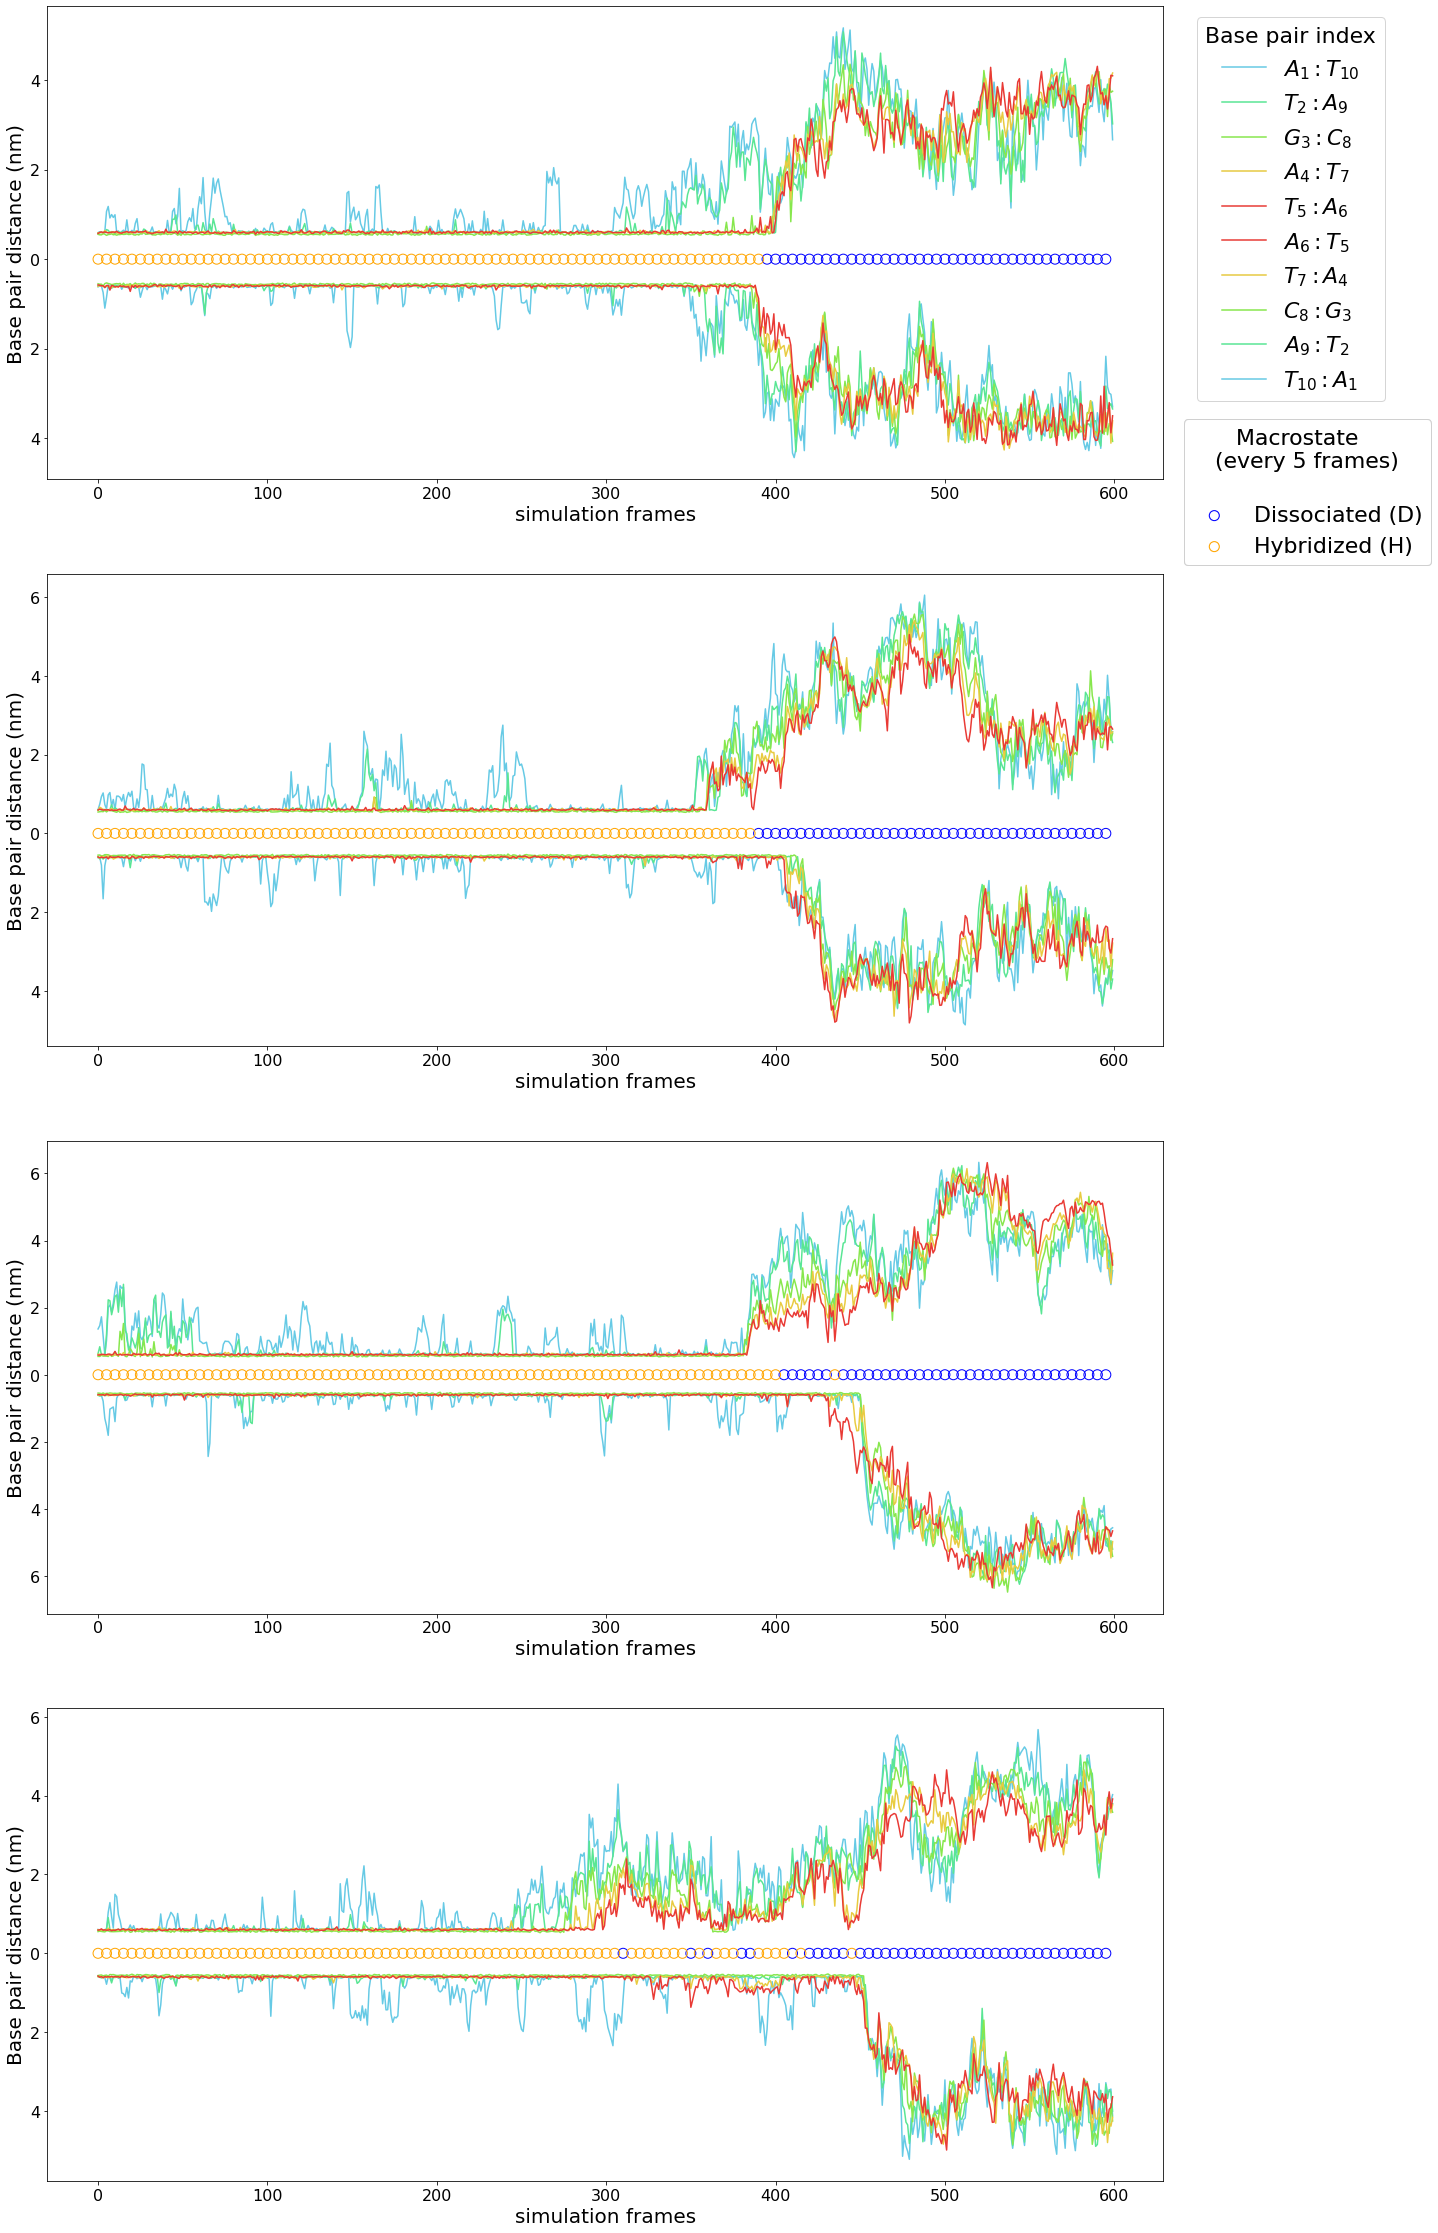

In [18]:
# only plot two characteristic examples
main_idxs = [6, 8]

# show more examples to include in the si, organize by hybrid then diss
hbr_idxs = [2, 1, 3, 7]
dis_idxs = [5, 9, 10, 13]

# choose which set to plot
plot_idxs = dis_idxs
save_prefix = 'dis'

dpi = 300
tick_font = 16
label_font = 22

ts = 0.03 #ns
cutoff = 1.5
fig, axes = plt.subplots(len(plot_idxs), figsize=(20, 10*len(plot_idxs)))
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
c_list = ['#66CAE5', '#59E694', '#87E74D','#E8CB41', '#E93A35']
focus = 200 # range to plot

hybrid_list, diss_list = [], []
print(np.shape(trim_list), np.shape(diag_list))

for j, (trim, diag) in enumerate(zip(trim_list, diag_list)):
    
    # calculate n base pairs bound:
    bound = diag > cutoff
    n_bound = np.sum(bound, axis=1)
    print(np.shape(n_bound))
    
    time, hybrid =  find_transition_time(n_bound) #GC_break(bound)
    if hybrid:
        hybrid_list.append(time)
    else:
        diss_list.append(time)
    
    if j in plot_idxs:
        ax = axes[plot_idxs.index(j)]
    
        # scatter plot to show state at each frame
        scat_leg_list = []

        #state_list = ['4bp-frayed', 'hybridized', 'dissociated']
        state_list = ['Hybridized (H)', 'Dissociated (D)']
        state_colors = ['orange', 'blue']
        stride = 5 # only plot state this frequently
        state_shifts  = [stride, 0]
        
        for i in reversed(range(len(state_list))):
            # center trim_idxs on at constant stride positions
            trim_idx = np.where(trim[focus:-focus][::stride]==i)[0]*stride
                
            c = state_colors[i]
            shift = state_shifts[i]
            trim_scat = ax.scatter(trim_idx, np.full(len(trim_idx), 0), 
                                   label=f'{state_list[i]}', marker='o', 
                                   s=100, facecolors='none', edgecolors=c)
            scat_leg_list.append(trim_scat)
            
            trim_old = trim_idx

        # plot each corresponding bp to show fraying
        for i in range(5):
            ax.plot(-1/diag[focus:-focus, i], label=str(i), c=c_list[i])
        for i in reversed(range(5)):
            ax.plot(1/diag[focus:-focus, i+5], label=str(i+5), c=c_list[4-i])

        loc = 'top right'
        handles, labels = ax.get_legend_handles_labels()
        #ax.set_title(f'traj {j+1}')
        ax.set_xlabel(f'simulation frames')
        ax.set_ylabel(f'Base pair distance (nm)')
        ax.tick_params(axis='both', labelsize=tick_font)

        # reflect permutable distances in labels
        bplabels = ['$A_{1}:T_{10}$', '$T_{2}:A_{9}$', '$G_{3}:C_{8}$', '$A_{4}:T_{7}$', '$T_{5}:A_{6}$', 
                    '$A_{6}:T_{5}$', '$T_{7}:A_{4}$', '$C_{8}:G_{3}$', '$A_{9}:T_{2}$', '$T_{10}:A_{1}$', ]
        
        # only seperate and plot legends for the first axis
        if plot_idxs.index(j) == 0:
            leg0 = ax.legend(handles=handles[:5]+handles[5:10][::-1], labels=bplabels[:10], fontsize=label_font, 
                             loc='top right', bbox_to_anchor=(1.02,1))
            leg0.set_title(title='Base pair index', prop = {'size':label_font})
            ax.add_artist(leg0)

            leg1 = ax.legend(handles[-2:], labels[-2:], fontsize=label_font,        
                             loc='bottom right', bbox_to_anchor=(1.25,.15))
            leg1.set_title(title='   Macrostate\n(every 5 frames)\n', prop = {'size':label_font})
            ax.add_artist(leg1)
            
        # make ytick labels all positive
        yticks =  ax.get_yticks()
        ax.set_yticklabels([int(abs(tick)) for tick in yticks])
    
print('hybrid mean = ', len(hybrid_list), np.mean(hybrid_list))
print('diss mean = ', len(diss_list), np.mean(diss_list))

print('hybrid std = ', np.std(hybrid_list))
print('diss std = ', np.std(diss_list))

#plt.savefig(f'../paper_figs/{save_prefix}_GC-mix_transitions.pdf', dpi=dpi, bbox_inches='tight')
#plt.savefig(f'../paper_figs/{save_prefix}_GC-mix_transitions.png', dpi=dpi, bbox_inches='tight')